In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import pprint as pprint
from scipy import stats
import pickle as pkl
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn.metrics import mean_squared_error
from sklearn.cross_validation import cross_val_score
%matplotlib inline

In [102]:
"""
Functions
"""

def calc_NMSE_error(X, y, model):
    '''returns in-sample error for already fit model.'''
    predictions = model.predict(X)
    mse = mean_squared_error(y, predictions)
    nmse = -1*mse
    return nmse

In [80]:
with open("../data/iterate/luther_model_data_full.pkl", 'rb') as picklefile:
    sale = pkl.load(picklefile)
    
# potential zipcode filter to NW side
zips_nw = [60611, 60610, 60654, 60642,
           60622, 60647, 60614, 60657,
           60639, 60641, 60630, 60618,
           60613, 60640, 60625, 60660,
           60626, 60659, 60645]

sale = sale[sale['zipcode'].isin(zips_nw)]

In [94]:
"""
build/filter/transform target and features
"""

model_params = ['price','bedrooms','bathrooms','area','median_income','duration_float','lot_size','year_built']

sale = sale.dropna(subset = model_params)

# filter down to correlation parameters
model = sale[model_params]

#filter out outliers
model = model[(np.abs(stats.zscore(model)) < 3).all(axis=1)]

model['price']=model['price'].apply(np.log10)
model['area']=model['area'].apply(np.log10)

"""
set up train test split
"""
# make data for linear regression
y = model.pop('price').values
X = StandardScaler().fit_transform(model)

# first split out 20% of the data as a validation set
X_training, X_holdout, y_training, y_holdout = train_test_split(X, y, test_size=0.2)

# now split out another 20% for cross validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3333333)

#build initial regression model

### cross validation testing
#setting up as a polynomial but using degree 1, just to have the easy option later
degree = 2
est = make_pipeline(PolynomialFeatures(degree), LinearRegression())
lr = LinearRegression(fit_intercept=True)

scores_R = cross_val_score(est,
                         X_training,
                         y_training,
                         cv=10)#, scoring='neg_mean_squared_error')
scores_RMSE = cross_val_score(est,
                         X_training,
                         y_training,
                         cv=10, scoring='neg_mean_squared_error')

print(model.shape)
print(np.mean(scores_R))


(1195, 7)
0.8280117815087766


In [104]:
"""
reduce parameters with lasso
"""

# make model with Lasso grid search on train subset of data
lasso = Lasso()
alphas = np.logspace(-5,1,num=6)
params = {'alpha': alphas, 'fit_intercept': [True,False]}
grid = GridSearchCV(lasso,params, cv=10, scoring='neg_mean_squared_error', n_jobs=1)
reduce_fit = make_pipeline(PolynomialFeatures(degree), grid)
reduce_fit.fit(X_train, y_train)
#print(reduce_fit.named_steps['gridsearchcv'].best_params_)
print(reduce_fit.named_steps['gridsearchcv'].best_score_)
#print(reduce_fit.named_steps['gridsearchcv'].best_estimator_.coef_[0:])

# check for overfitting by testing against 
cv2 = reduce_fit.named_steps['gridsearchcv'].best_estimator_
cv2.fit(X_train,y_train)
print(calc_NMSE_error(X_test,y_test,cv2))

-0.02029226988837509
-0.026237839339829087


Model R^2 of: 0.7889033028655257


/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


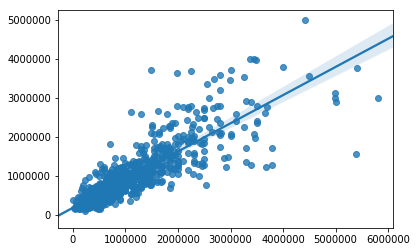

In [110]:
'''
Apply to full dataset
'''

# errors on holdout
errors_fit = cv2.fit(X_training,y_training)
final_error = errors_fit.score(X_holdout,y_holdout)
print('Model R^2 of: ' + str(final_error))

# fit to model
final_model = cv2.fit(X,y)

# make a plot
y_pred = final_model.predict(X)
ax = sns.regplot(10**y,10**y_pred)